In [3]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import cv2
from scipy.ndimage.filters import gaussian_filter
from copy import deepcopy

import os

In [4]:
'''
FER2013 emotion abels:
0 - Angry
1 - Disgust
2 - Fear
3 - Happy
4 - Sad
5 - Surprise
6 - Neutral
'''

def load_fer2013(filename='fer2013/fer2013.csv'):
    df = pd.read_csv(filename, sep=',',header=0)
    images = []
    labels = []
    for each in df['pixels'].tolist():
        pom = np.array(each.split(' '))
        pom = np.reshape(pom, (48,48))
        #pom = cv2.normalize(pom.astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
        images.append(pom)
    for each in df['emotion'].tolist():
        labels.append(int(each))
    return images, labels

'''
CC emotion labels:
1 - Angry 45
2 - Contempt 18
3 - Disgust 59
4 - Fear 25
5 - Happy 69
6 - Sadness 28
7 - Surprise 83
'''
def load_cohn_canade(rootdir='Cohn_canade/extended-cohn-kanade-images/',
                     rootdir2='Cohn_canade/Emotion_labels/Emotion'):
    f_img = []
    f_img_path = []
    for subdir, dirs, files in os.walk(rootdir):
        for file in files:
            f_img_path.append(os.path.join(subdir, file))
            f_img.append(f_img_path[-1].split('/')[-1].split('.')[0])


    f_lbl = []
    f_lbl_path = []
    for subdir, dirs, files in os.walk(rootdir2):
        for file in files:
            f_lbl_path.append(os.path.join(subdir, file))
            f_lbl.append(f_lbl_path[-1].split('/')[-1].split('.')[0][:-8])

    labels = []
    images = []
    for i in range(len(f_lbl)):
        for j in range(len(f_img)):
            if f_lbl[i] == f_img[j]:
                labels.append(int(np.loadtxt(f_lbl_path[i])))
                images.append(cv2.imread(f_img_path[j],0))
    return images, labels

# HAAR Cascades
def locate_face(img_list, label_list, haar='haarcascade_frontalface_default.xml'):
    face_cascade = cv2.CascadeClassifier(haar)
    ilist = deepcopy(img_list)
    llist = deepcopy(label_list)
    j = []
    for i in range(len(ilist)):
        ilist[i] = gaussian_filter(ilist[i], 1)
        faces = face_cascade.detectMultiScale(ilist[i], 1.3, 5)
        if len(faces) == 1:
            for (x,y,w,h) in faces:    
                ilist[i] = ilist[i][y:(y+h), x:(x+w)]
                ilist[i] = cv2.resize(ilist[i], (48, 48))
        else:
            print('Either more than 1 or no face detected.')
            print('Removing image ' + str(i) + ' from collection.')
            j.append(i)
    for each in j:
        del ilist[each]
        del llist[each]

    return ilist, llist

def floatify(ilist):
    for i in range(len(ilist)):
        ilist[i] = cv2.normalize(ilist[i].astype('float'), None, 0.0, 1.0, cv2.NORM_MINMAX)
    return ilist

def load_everything():
    fer_images, fer_labels = load_fer2013()
    cc_images, cc_labels = load_cohn_canade()
    
    cc_images, cc_labels = locate_face(cc_images, cc_labels)
    cc_images = floatify(cc_images)
    
    return fer_images, fer_labels, cc_images, cc_labels

In [5]:
fer_images, fer_labels, cc_images, cc_labels = load_everything()

Either more than 1 or no face detected.
Removing image 134 from collection.


0


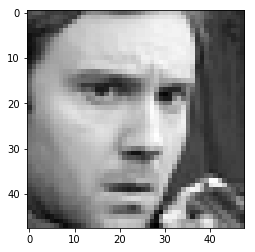

[[ 0.29648241  0.34673367  0.35678392 ...,  0.20603015  0.16080402
   0.15075377]
 [ 0.27135678  0.25125628  0.2361809  ...,  0.22613065  0.20603015
   0.16582915]
 [ 0.1959799   0.16080402  0.2160804  ...,  0.19095477  0.22613065
   0.18090452]
 ..., 
 [ 0.40201005  0.27135678  0.15577889 ...,  0.30653266  0.22613065
   0.16080402]
 [ 0.33165829  0.35678392  0.34170854 ...,  0.47236181  0.29648241
   0.1758794 ]
 [ 0.33165829  0.30653266  0.36683417 ...,  0.47738693  0.49246231
   0.35678392]]


IndexError: list index out of range

In [4]:
print(fer_labels[0])
plt.imshow(fer_images[0], cmap = 'gray')
plt.show()
print(fer_images[0])

print(cc_labels[0])
plt.imshow(image_list[0], cmap = 'gray')
plt.show()
print(cc_images[0])

In [6]:
print(len(fer_images), len(fer_labels), len(cc_images), len(cc_labels))

35887 35887 326 326


In [7]:
def angry_not_angry_labels(labels):
    new_labels = []
    for i in range(len(labels)):
        if labels[i] == 0:
            new_labels.append(1)
        else:
            new_labels.append(0)

    return new_labels

In [8]:
angry_binary_labels = angry_not_angry_labels(fer_labels)

In [9]:
X_train = []
Y_train = []
X_test = []
Y_test = []

# they are already shuffled
for i in range(len(fer_images)):
    if i < len(fer_images)/0.3:
        X_train.append(fer_images[i].astype("uint8"))
        Y_train.append(angry_binary_labels[i])
    else:
        Y_test.append(fer_images[i].astype("uint8"))
        Y_test.append(angry_binary_labels[i])

In [10]:
sift = cv2.xfeatures2d.SIFT_create()

In [11]:
fer_images[0].shape

(48, 48)

In [12]:
X_train[0].shape

(48, 48)

In [13]:
fer_images[0]

array([['70', '80', '82', ..., '52', '43', '41'],
       ['65', '61', '58', ..., '56', '52', '44'],
       ['50', '43', '54', ..., '49', '56', '47'],
       ..., 
       ['91', '65', '42', ..., '72', '56', '43'],
       ['77', '82', '79', ..., '105', '70', '46'],
       ['77', '72', '84', ..., '106', '109', '82']], 
      dtype='<U3')

In [14]:
X_train[0]

array([[ 70,  80,  82, ...,  52,  43,  41],
       [ 65,  61,  58, ...,  56,  52,  44],
       [ 50,  43,  54, ...,  49,  56,  47],
       ..., 
       [ 91,  65,  42, ...,  72,  56,  43],
       [ 77,  82,  79, ..., 105,  70,  46],
       [ 77,  72,  84, ..., 106, 109,  82]], dtype=uint8)

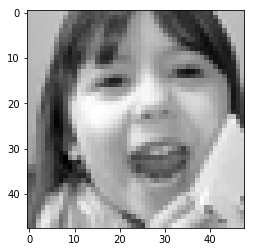

In [16]:
plt.imshow(fer_images[111].astype('float'), cmap = 'gray')
plt.show()

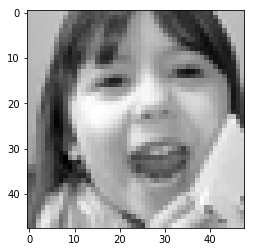

In [17]:
plt.imshow(X_train[111].astype('float'), cmap = 'gray')
plt.show()

In [22]:
#cv_gray_image = cv2.cvtColor(X_train[0], cv2.COLOR_BGR2GRAY)
kp, image_sift = sift.detectAndCompute(X_train[0], None)

In [23]:
img = cv2.drawKeypoints(X_train[0], kp, outImage=image_sift, 
                        flags= cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

cv2.imwrite('example_keypoints.jpg',img.astype('float'))

True

In [24]:
def get_SIFT_descriptors(images):
    SIFT_descr = []
    for image in images:
        #cv_gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kp, image_sift = sift.detectAndCompute(image.astype("uint8"), None)
        SIFT_descr.append(image_sift)
    return SIFT_descr

In [25]:
train_descriptors = get_SIFT_descriptors(X_train)